# OpenFOAM projection integrator

This program calculates the path integral of a field (ie rho) along one of the principal axes.
It uses point-interpolated data exported from Paraview 5.9
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 23/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [90]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import glob, os, tqdm
import scipy.io, scipy.spatial, scipy.interpolate, scipy.ndimage
from joblib import Parallel, delayed
%matplotlib notebook

In [124]:
# Load OF data
directory = '/Users/dduke/Desktop/PMDI-papers-data/Validation/isosurface/'
print('reading file...')
ofdata = np.genfromtxt(directory+'threshold_yMean99_134a15pcEtOH.csv',delimiter=',',names=True,\
                       usecols=('Points0','Points1','Points2','rhoMean'))
print('Read %i records.' % (len(ofdata)))

reading file...
Read 5365256 records.


In [143]:
# Select the scalar field to interpolate
scalarField = ofdata['rhoMean'] # kg/m^3 = ug/mm^3

scalarFieldUnits='[kg/m$^3$]'
integratedUnits='[$\mu g / mm^2$]'

In [126]:
# Determine the axis values where we will cut slices. 
# By default we cut slices in 'z' and integrate in 'x'
x='Points0'; y='Points2'; z = 'Points1'

<IPython.core.display.Javascript object>


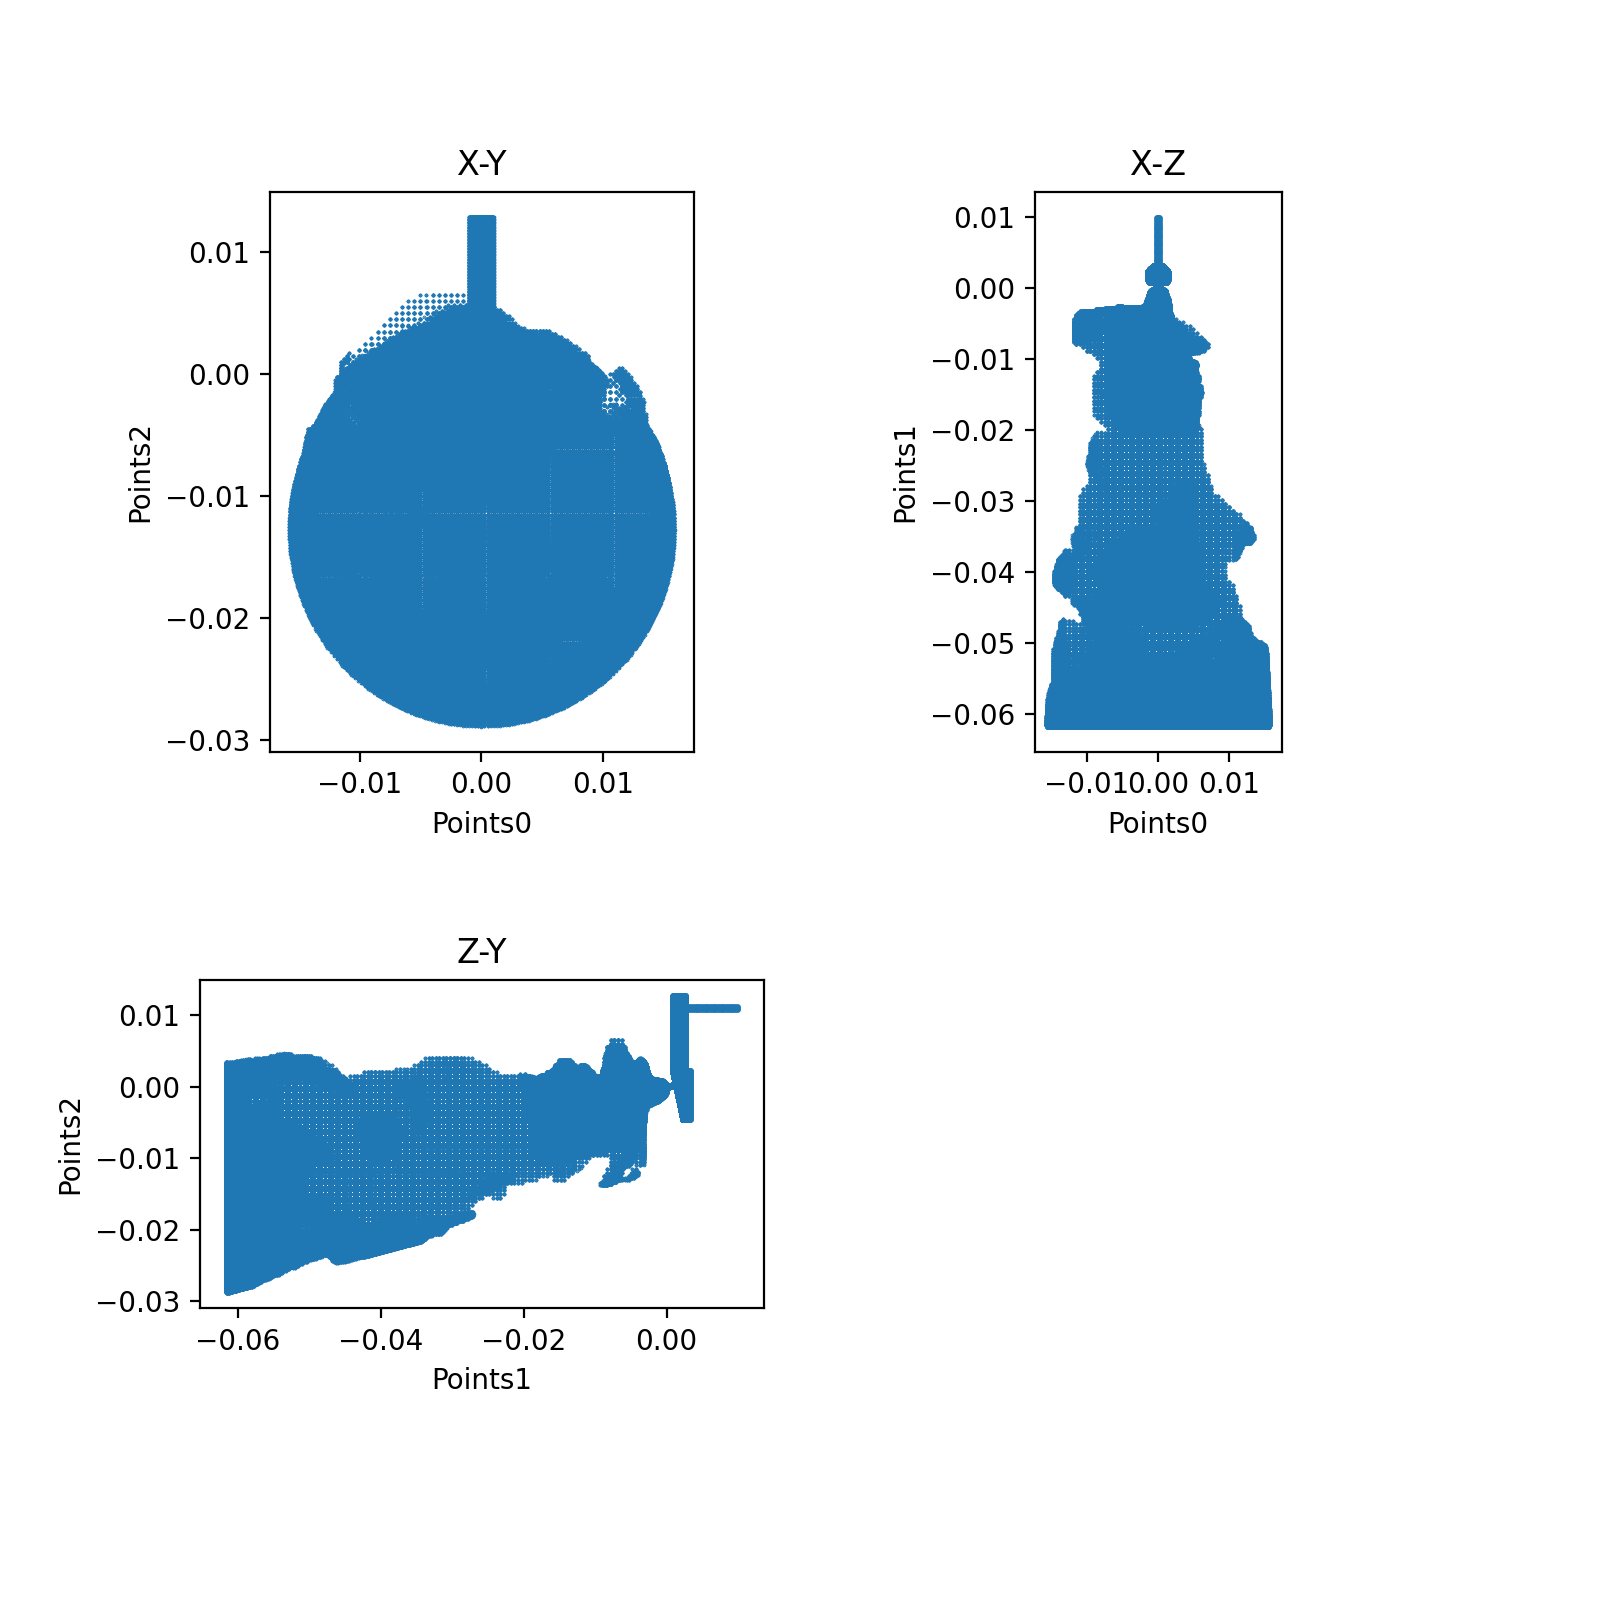

In [127]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(221)
ax.set_aspect('equal')
plt.scatter(ofdata[x],ofdata[y],marker='.',s=.5)
plt.xlabel(x); plt.ylabel(y); plt.title('X-Y')

ax=fig.add_subplot(222)
ax.set_aspect('equal')
plt.scatter(ofdata[x],ofdata[z],marker='.',s=.5)
plt.xlabel(x); plt.ylabel(z); plt.title('X-Z')

ax=fig.add_subplot(223)
ax.set_aspect('equal')
plt.scatter(ofdata[z],ofdata[y],marker='.',s=.5)
plt.xlabel(z); plt.ylabel(y); plt.title('Z-Y');

In [167]:
# Use the Z axis for interpolation. Find suitable Z values.

zp = np.linspace(-0.025, 0, 26)

print(z,ofdata[z].min(),ofdata[z].max())
print('Interpolate at:', np.round(zp*1e3,3),'mm')

Points1 -0.0617170259 0.00999999978
Interpolate at: [-25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12.
 -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.] mm


In [168]:
def sliceInterpolatorFun(z_, showFigure=True):

    # Get smallest viable subset of data that is nearby the point for speedy interpolation
    for tol in np.logspace(-6,0,12):
        idx = np.where(np.abs(ofdata[z]-z_)<tol)[0]
        if(len(idx)>10000): break

    # Develop a suitable grid in the X & Y axes for interpolating onto
    xp = np.linspace(ofdata[x][idx].min(), ofdata[x][idx].max(), 257) # unequal no pts to ensure no axis mix ups
    yp = np.linspace(ofdata[y][idx].min(), ofdata[y][idx].max(), 256)
    Xp, Yp = np.meshgrid(xp, yp)
    
    if np.any(~np.isnan(scalarField[idx])):
    
        # Generate a triangulation for this subset of data.
        print("Triangulating at z=%.3f\u00B1%.3f mm using %i points (%.1f%%)" % (z_*1e3,tol*1e3,len(idx),\
                                                                                 100*len(idx)/len(scalarField)))

        # Delaunay triangulation
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
        tri = scipy.spatial.Delaunay(np.transpose(np.vstack((ofdata[x][idx], ofdata[y][idx], ofdata[z][idx]))),\
                                     furthest_site=False, incremental=False, qhull_options=None)

        # Linear N-dimensional interpolation
        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html            
        fInt = scipy.interpolate.LinearNDInterpolator(tri, scalarField[idx], fill_value=np.nan, rescale=False)

        interpolated = fInt(Xp,Yp,z_)
        
    else: 
        interpolated=np.zeros_like(Xp)
        
    
    # Make figure?
    if showFigure:
        fig=plt.figure()
        ax=fig.add_subplot(111)
        ax.set_aspect('equal')
        p_=ax.pcolormesh(xp*1e3,yp*1e3,interpolated,cmap='jet')
        plt.colorbar(p_)
        plt.xlabel(x+' [mm]')
        plt.ylabel(y+' [mm]')
        plt.title('%s, Z = %f' % (scalarFieldUnits,z_))

    # X-integral
    integral = np.trapz(np.nan_to_num(interpolated),x=xp,axis=1)
    
    return (yp,integral,xp,interpolated,len(idx))
    

In [169]:
# Loop over Z values
#integrals=[ sliceInterpolatorFun(z_, False) for z_ in zp ]
integrals = Parallel(n_jobs=-1,verbose=20)(delayed(sliceInterpolatorFun)(z_, False) for z_ in zp)

#Check n points in interp.
for i in range(len(integrals)): print('z=%.3f mm' % (zp[i]*1e3),integrals[i][4],'pts')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of  26 | elapsed:    6.5s remaining:   27.1s
[Parallel(n_jobs=-1)]: Done   7 out of  26 | elapsed:    8.8s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   9 out of  26 | elapsed:    9.8s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done  11 out of  26 | elapsed:   10.8s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  13 out of  26 | elapsed:   11.8s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  15 out of  26 | elapsed:   12.2s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:   13.1s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  19 out of  26 | elapsed:   17.8s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  21 out of  26 | elapsed:   23.9s remaining:    5.7s
[Paralle

z=-25.000 mm 33791 pts
z=-24.000 mm 122907 pts
z=-23.000 mm 392234 pts
z=-22.000 mm 737140 pts
z=-21.000 mm 1078367 pts
z=-20.000 mm 21724 pts
z=-19.000 mm 156500 pts
z=-18.000 mm 20480 pts
z=-17.000 mm 15105 pts
z=-16.000 mm 21116 pts
z=-15.000 mm 20747 pts
z=-14.000 mm 20892 pts
z=-13.000 mm 20604 pts
z=-12.000 mm 20275 pts
z=-11.000 mm 20455 pts
z=-10.000 mm 17135 pts
z=-9.000 mm 16445 pts
z=-8.000 mm 18805 pts
z=-7.000 mm 19291 pts
z=-6.000 mm 14382 pts
z=-5.000 mm 11533 pts
z=-4.000 mm 46524 pts
z=-3.000 mm 36817 pts
z=-2.000 mm 11500 pts
z=-1.000 mm 33562 pts
z=0.000 mm 17378 pts


[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.8min finished


<IPython.core.display.Javascript object>


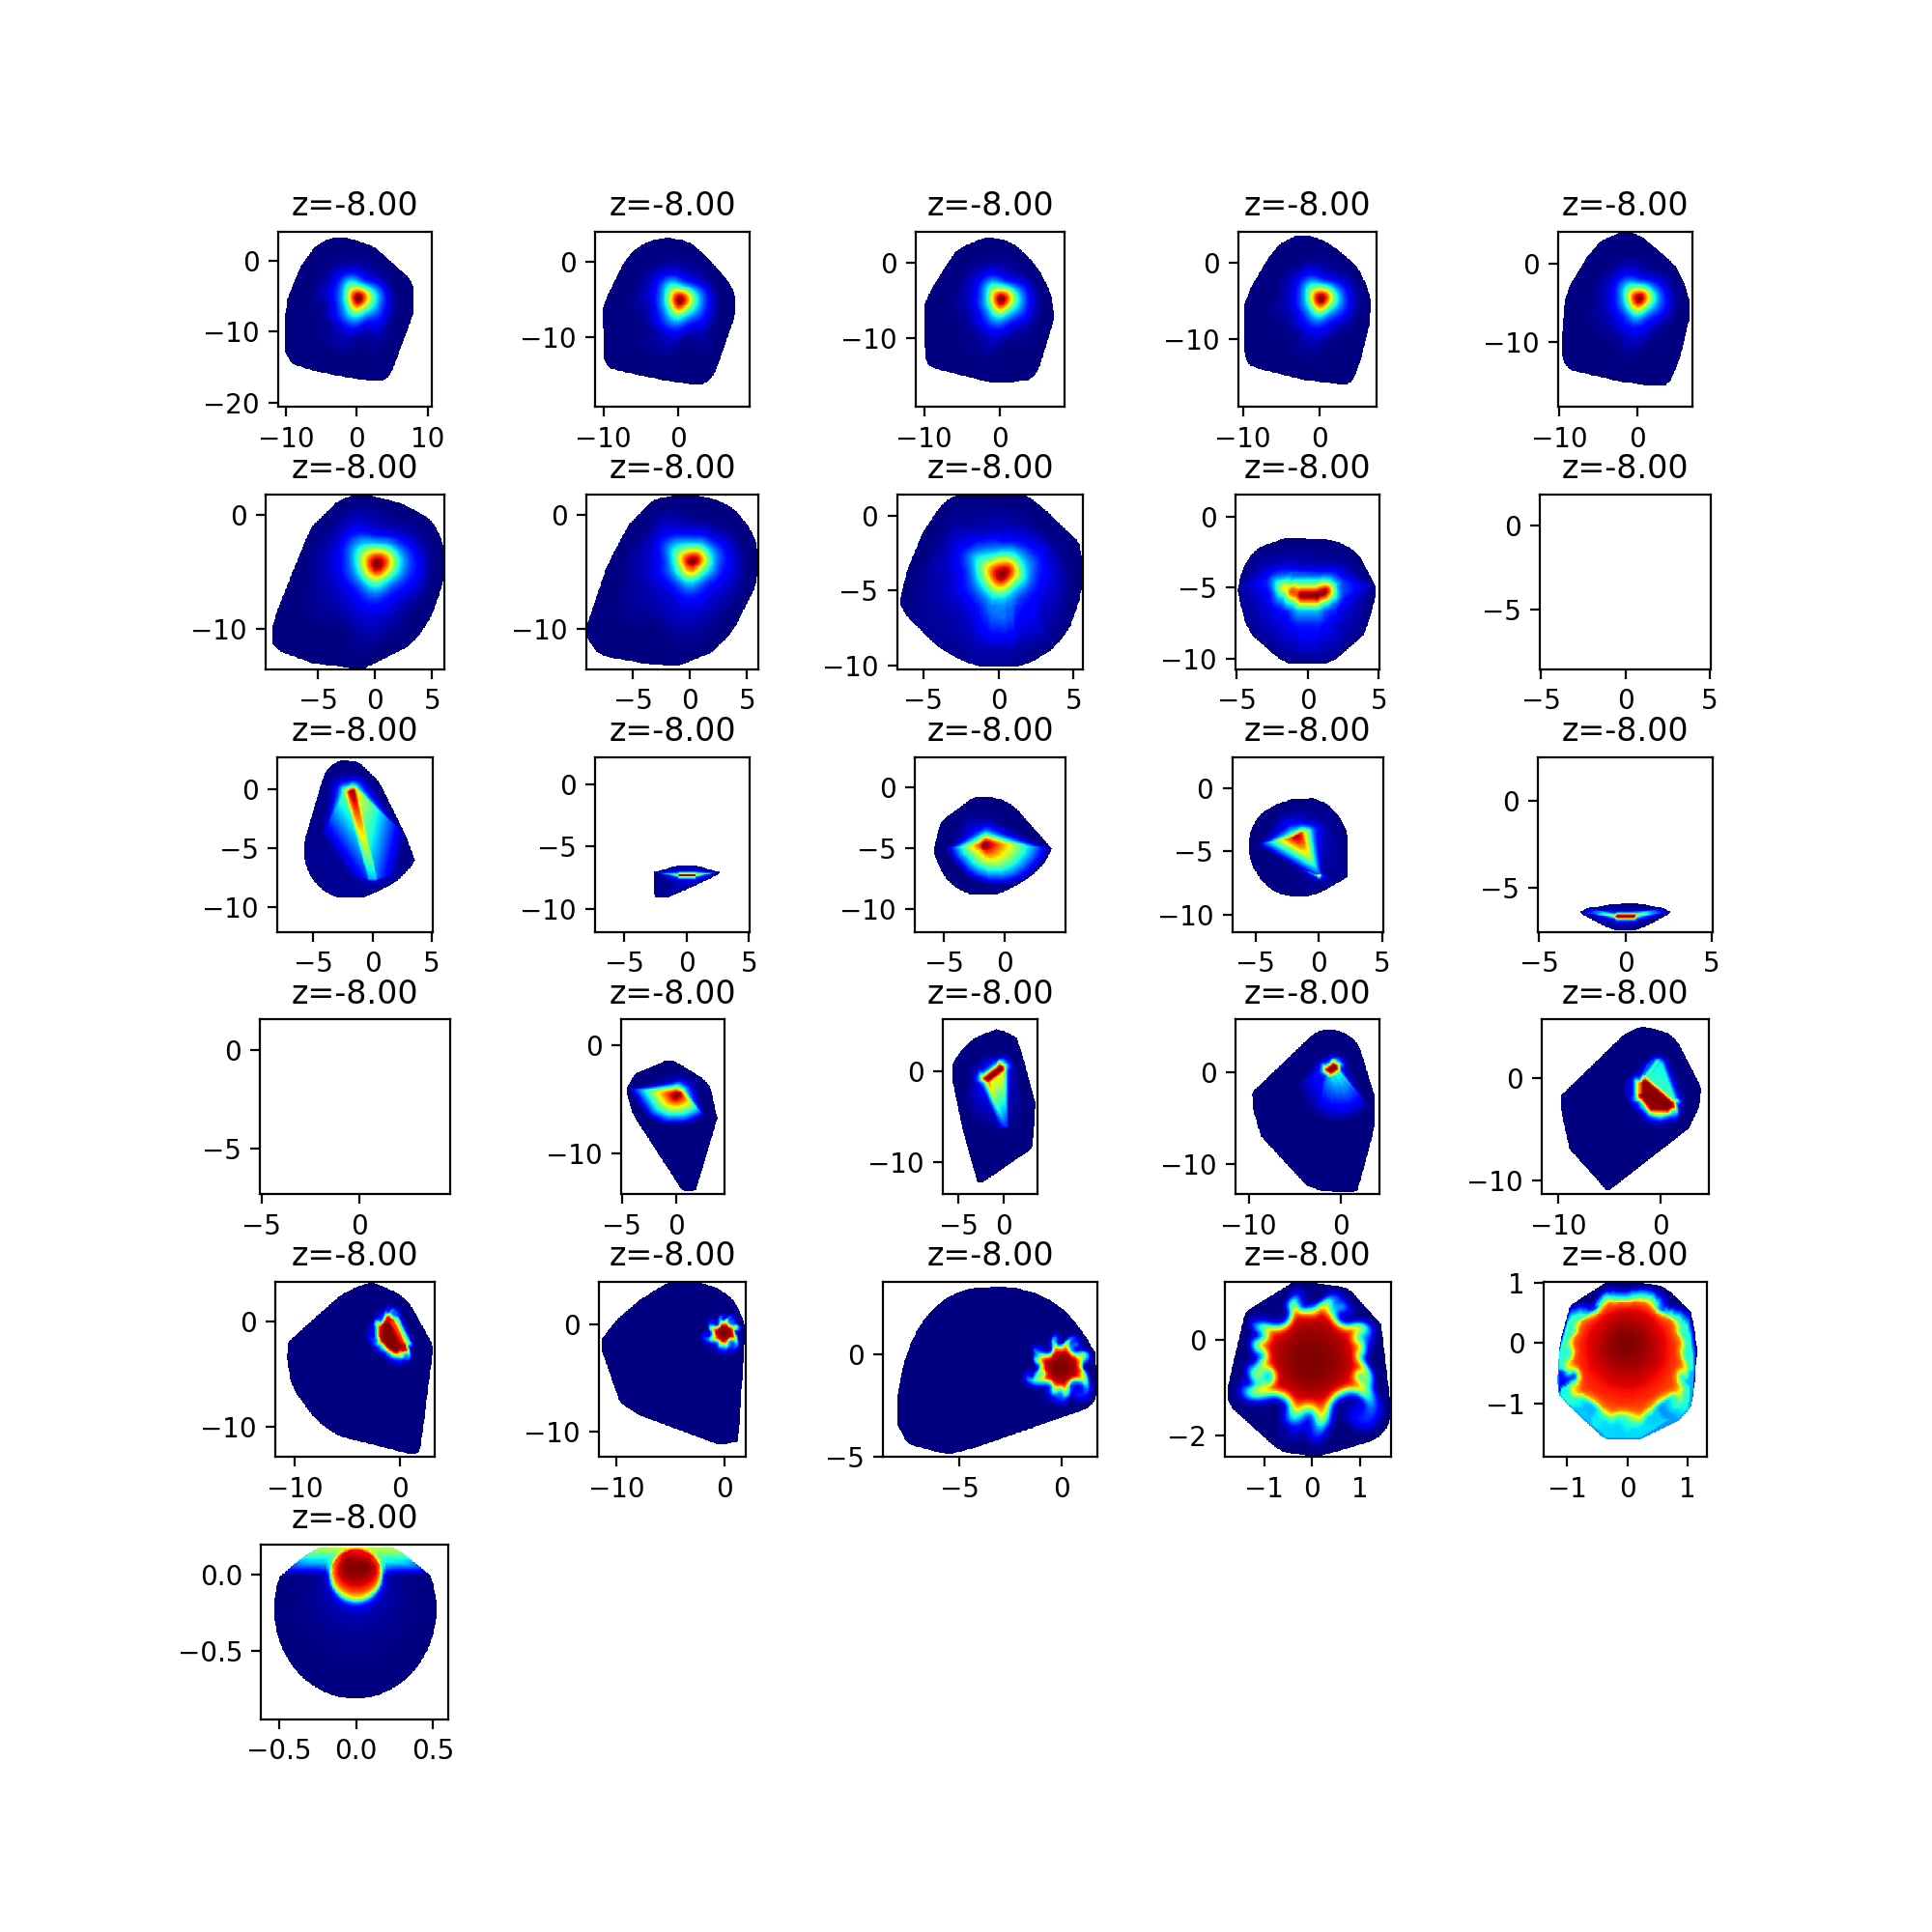

In [175]:
# Plot slices
fig=plt.figure(figsize=(10,10))
for i in range(len(integrals)):
    yp,integral,xp,interpolated,l = integrals[i]
    ax=fig.add_subplot(6,5,1+i)
    ax.set_aspect('equal')
    p_=ax.pcolormesh(xp*1e3,yp*1e3,interpolated,cmap='jet')
    #plt.colorbar(p_)
    #plt.xlabel(x+' [mm]')
    #plt.ylabel(y+' [mm]')
    plt.title('z=%.2f' % (z_*1e3))
plt.subplots_adjust(hspace=.5,wspace=.4)

<IPython.core.display.Javascript object>


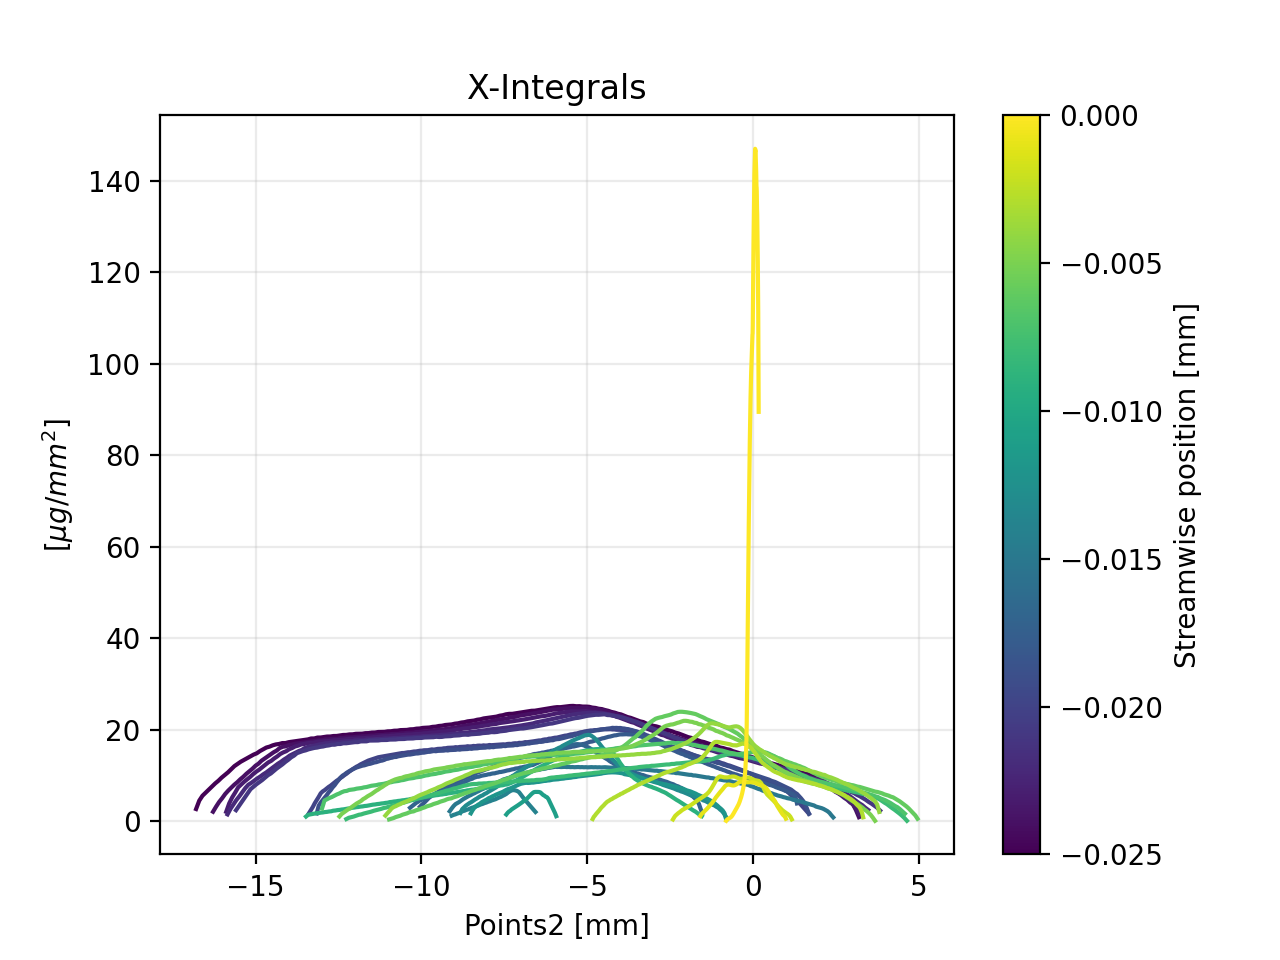

In [181]:
# Plot integrals

recenter=False

fig=plt.figure()
ax=fig.add_subplot(111)
cmap=plt.cm.viridis
dummy_cax = ax.scatter(zp, zp, c=zp, cmap=cmap)
plt.cla()

#ax.set_yscale('log')
plt.grid(alpha=.25)



for i in range(len(integrals)):
    
    if recenter:
        maxi = np.where(integrals[i][1] == np.nanmax(integrals[i][1]))[0][0]
        x0 = integrals[i][0][maxi]
    else:
        x0=0
        
    y_ = (integrals[i][0]-x0)*1e3
    x_ = integrals[i][1]*1e3
    
    x_[x_==0]=np.nan
        
    ax.plot(y_, x_,label='Z = %.3f mm' % (zp[i]*1e3),\
            c=cmap((zp[i]-zp.min())/(zp.max()-zp.min())))

plt.title('X-Integrals')
plt.xlabel('%s [mm]' % y)
plt.ylabel(integratedUnits)
cb=plt.colorbar(dummy_cax,ax=ax)
cb.set_label('Streamwise position [mm]')


In [ ]:
# Load X-ray data....

